In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import local_acq, phase_ucb_acq, generate, likelihood

 /Users/brianmontambault/anaconda/envs/gp-rl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

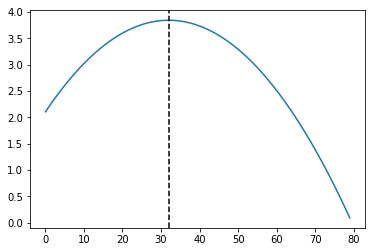

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [48]:
learning_rate_params = [0, 0, 350, 350]
stay_penalty_params = [0, -10, 0, -10]
temp_params = [.01, .1, 1]
trials = np.arange(20)
titles = ['Local Search', 'Local Search (Stay Penalty)', 'Gradient Ascent', 'Gradient Ascent (Stay Penalty)']

In [49]:
data = [[generate(local_acq, {'learning_rate': [learning_rate_params[i]], 'stay_penalty': [stay_penalty_params[i]], 'temperature': [temp_params[j]]},
        neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0] for i in range(len(learning_rate_params))] for j in range(len(temp_params))]

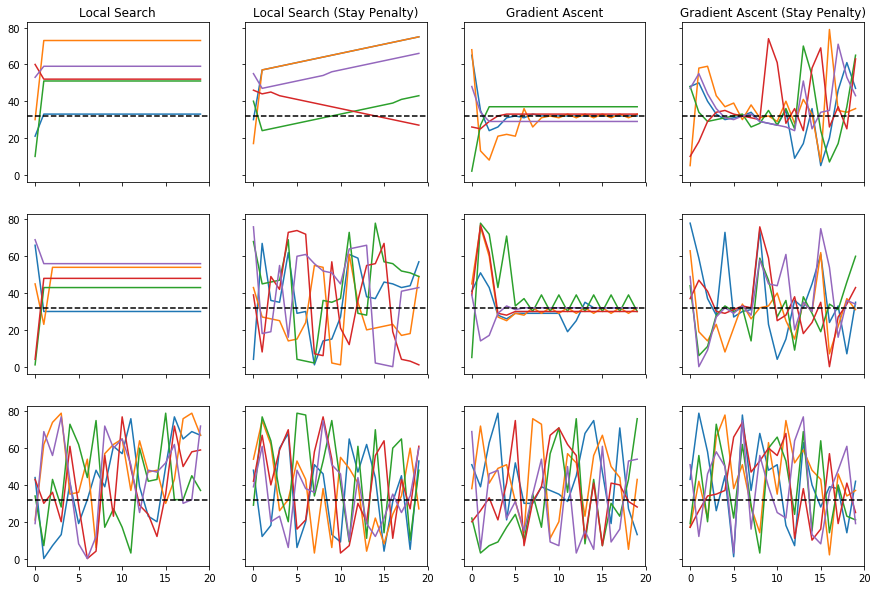

In [50]:
fig, axes = plt.subplots(len(temp_params), len(learning_rate_params), sharex=True, sharey=True, figsize=(15,10))
for j in range(len(temp_params)):
    for i in range(len(learning_rate_params)):
        actions = data[j][i][:,:,5].argmax(axis=2)
        axes[j][i].plot(actions[:5].T);
        axes[j][i].axhline(y=fmax, ls='--', c='black');
        if j == 0:
            axes[j][i].set_title(titles[i])

In [55]:
def plot_func(strategy, temp, participant, trial):
    
    strategy_idx = titles.index(strategy)
    temp_idx = temp_params.index(temp)
    
    trial_data = data[int(temp_idx)][int(strategy_idx)][int(participant)][int(trial)]
    utility = trial_data[10]
    norm_utility = utility/utility.sum()
    
    
    prob = trial_data[11]
    action = trial_data[5].argmax()
    x = np.arange(80)
    plt.plot(x, utility)
    plt.plot(x, prob)
    plt.axvline(x=action, color='red')
    #plt.ylim(0, 1)
    
y=interactive(plot_func, strategy=titles, temp=temp_params, participant=list(range(10)), trial=(0,19,1));
display(y)

interactive(children=(Dropdown(description='strategy', options=('Local Search', 'Local Search (Stay Penalty)', 'Gradient Ascent', 'Gradient Ascent (Stay Penalty)'), value='Local Search'), Dropdown(description='temp', options=(0.01, 0.1, 1), value=0.01), Dropdown(description='participant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), IntSlider(value=9, description='trial', max=19), Output()), _dom_classes=('widget-interact',))

## Learning Rate Prior

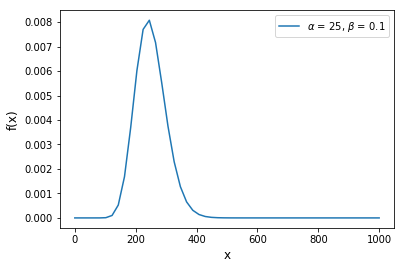

In [9]:
x = np.linspace(0, 1000)
alphas = [25]
betas = [.1]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

## Local Search

In [10]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][0], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    local_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

In [ ]:
pm.traceplot(local_trace);

## Local Search (Stay Penalty)

In [ ]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][1], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    local_penalty_trace = pm.sample(200)

In [ ]:
pm.traceplot(local_penalty_trace);

## Gradient Ascent

In [ ]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][2], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    gradient_trace = pm.sample(200)

In [ ]:
pm.traceplot(gradient_trace);

## Gradient Ascent (Stay Penalty)

In [ ]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Normal('stay_penalty', 0, 20, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][3], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    gradient_penalty_trace = pm.sample(200)

In [ ]:
pm.traceplot(gradient_penalty_trace);